In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Conv3D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils

import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing

img_rows, img_cols, img_depth = 64, 64, 64

In [38]:
root_dir = 'dataset_withlabel/'
listing = os.listdir(root_dir)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}

In [39]:
frames = []
labels = []
nongesture_count = 0
for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
    images = data['images']
    label = data['labels']
    num_frame = images.shape[0]

    for i in range(0, num_frame-64, 5):
        gt = label[i:i+64]
        if np.sum(gt) > 32:
            vol = images[i:i+64]
            vol = vol.reshape(64,64,64)
            frames.append(vol)
            labels.append(np.max(gt))
        if np.sum(gt) == 0 and nongesture_count < 2000:
            vol = images[i:i+64]
            vol = vol.reshape(64,64,64)
            frames.append(vol)
            labels.append(np.max(gt))
            nongesture_count = nongesture_count + 1

In [46]:
num_samples = len(frames)
frames[10].shape

(64, 64, 64)

In [47]:
X = np.zeros((num_samples, 1, img_rows, img_cols, img_depth))

In [6]:
frames_arr =np.array(frames)

In [48]:
for h in range(num_samples):
#     X[h][0][:][:][:] = frames_arr[h,:,:,:]
    X[h][0][:][:][:] = frames[h]

In [50]:
del frames

In [51]:
X = np.swapaxes(X, 1, 4)
print(X.shape, 'train samples')

(8661, 64, 64, 64, 1) train samples


In [52]:
batch_size = 4
nb_classes = 5
nb_epoch = 100
patch_size = 64

nb_filters = [32, 32]
nb_pool = [2, 2]
nb_conv = [5, 5]

In [53]:
y = np_utils.to_categorical(labels, nb_classes)



X = X.astype('float32')
X -= np.mean(X)
X /= np.max(X)

In [62]:
model = Sequential()
print(nb_filters[0], 'filters')
print('input shape', img_rows, 'rows', img_cols, 'cols', patch_size, 'patchsize')

model.add(Conv3D(16,
                 (3, # depth
                  3, # rows
                  3), # cols
                 input_shape=(patch_size, img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(32,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(64,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(64,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(128,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(nb_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

32 filters
input shape 64 rows 64 cols 64 patchsize


In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 64, 64, 64, 16)    448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 32, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 32, 32)    13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 16, 32)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 16, 16, 64)    55360     
__________

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

hist = model.fit(
X_train,
y_train,
validation_data=(X_val, y_val),
batch_size=batch_size,
epochs=nb_epoch,
shuffle=True
)

MemoryError: 

In [57]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

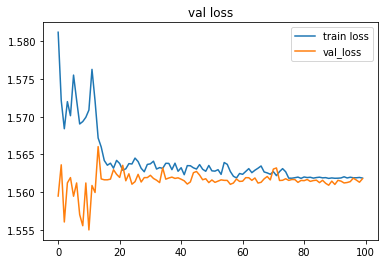

In [58]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

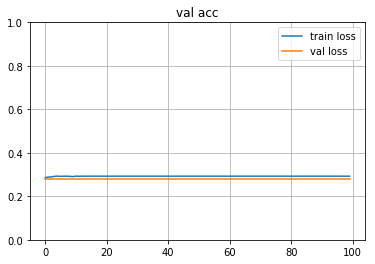

In [59]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train loss', 'val loss'])
plt.grid(True)
plt.ylim(0,1)

In [60]:
X.shape

(8661, 64, 64, 64, 1)

In [61]:
from keras import backend as K
K.clear_session()

In [66]:
np.save('X.npy', X)

In [67]:
np.save('y.npy', y)